In [1]:
from comp_overrule import learn_srules, learn_s_orules, get_overlap_violations, get_overlap
from comp_overrule_knn import learn_orules as learn_knnrules
from comp_overrule_clr import learn_orules as learn_clrrules

from comp_overrule import plt_cl_lit, plt_sem, get_sem_optim
from utils import rule_str, rules_stats, transcribe, recent_model, read_model
from comp_preprocessing import get_data, get_lbl

from comp_causalmodel import causal_eval, propensity_model, bootstrap_effects, placebo_effects

import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn3
import matplotlib.pyplot as plt
import time

%load_ext autoreload
%autoreload 2

folder = '/home/victora/PositivityViolation/'

def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn

### Learn support rules

In [11]:
import glob
selects = sorted(glob.glob('data/fp_select' + '*.csv'))
ctrys = ['et', 'ng', 'sl', 'br', 'zm', 'lb', 'ug']

100%|██████████| 10/10 [00:00<00:00, 26395.87it/s]

100%|██████████| 10/10 [00:00<00:00, 18699.53it/s]

100%|██████████| 10/10 [00:00<00:00, 41323.19it/s]

100%|██████████| 10/10 [00:00<00:00, 35394.97it/s]

100%|██████████| 10/10 [00:00<00:00, 42668.40it/s]

100%|██████████| 10/10 [00:00<00:00, 46759.24it/s]

100%|██████████| 10/10 [00:00<00:00, 29046.43it/s]

100%|██████████| 10/10 [00:00<00:00, 21982.73it/s]

100%|██████████| 10/10 [00:00<00:00, 1765.35it/s]

100%|██████████| 10/10 [00:00<00:00, 191.10it/s]


0.898562124672249


100%|██████████| 10/10 [00:00<00:00, 20846.44it/s]

100%|██████████| 10/10 [00:00<00:00, 26346.13it/s]

100%|██████████| 10/10 [00:00<00:00, 41610.16it/s]

100%|██████████| 10/10 [00:00<00:00, 48210.39it/s]

100%|██████████| 10/10 [00:00<00:00, 31726.96it/s]

100%|██████████| 10/10 [00:00<00:00, 28149.69it/s]

100%|██████████| 10/10 [00:00<00:00, 6477.69it/s]

100%|██████████| 10/10 [00:00<00:00, 44906.90it/s]

100%|██████████| 10/10 [00:00<00:00, 40800.62it/s]

100%|██████████| 10/10 [00:00<00:00, 233.61it/s]


0.9458549907896316


100%|██████████| 10/10 [00:00<00:00, 29599.89it/s]

100%|██████████| 10/10 [00:00<00:00, 41943.04it/s]

100%|██████████| 10/10 [00:00<00:00, 41692.88it/s]

100%|██████████| 10/10 [00:00<00:00, 51909.70it/s]

100%|██████████| 10/10 [00:00<00:00, 26664.36it/s]

100%|██████████| 10/10 [00:00<00:00, 49461.13it/s]

100%|██████████| 10/10 [00:00<00:00, 6179.91it/s]

100%|██████████| 10/10 [00:00<00:00, 27703.46it/s]

100%|██████████| 10/10 [00:00<00:00, 42.81it/s]


0.8406674896710964


100%|██████████| 10/10 [00:00<00:00, 1140.22it/s]

100%|██████████| 10/10 [00:00<00:00, 41404.78it/s]

100%|██████████| 10/10 [00:00<00:00, 47393.27it/s]

100%|██████████| 10/10 [00:00<00:00, 52103.16it/s]

100%|██████████| 10/10 [00:00<00:00, 55043.36it/s]

100%|██████████| 10/10 [00:00<00:00, 31347.56it/s]

100%|██████████| 10/10 [00:00<00:00, 54755.93it/s]

100%|██████████| 10/10 [00:00<00:00, 50351.79it/s]

100%|██████████| 10/10 [00:00<00:00, 51653.99it/s]

100%|██████████| 10/10 [00:00<00:00, 228.85it/s]


0.9148415885765283


100%|██████████| 10/10 [00:00<00:00, 450.78it/s]

100%|██████████| 10/10 [00:00<00:00, 33852.33it/s]

100%|██████████| 10/10 [00:00<00:00, 32665.92it/s]

100%|██████████| 10/10 [00:00<00:00, 21334.20it/s]

100%|██████████| 10/10 [00:00<00:00, 32388.45it/s]

100%|██████████| 10/10 [00:00<00:00, 33314.57it/s]

100%|██████████| 10/10 [00:00<00:00, 22745.68it/s]

100%|██████████| 10/10 [00:00<00:00, 26698.31it/s]

100%|██████████| 10/10 [00:00<00:00, 35940.91it/s]

100%|██████████| 10/10 [00:00<00:00, 175.73it/s]


0.9127075507158575


100%|██████████| 10/10 [00:00<00:00, 9758.73it/s]

100%|██████████| 10/10 [00:00<00:00, 37718.56it/s]

100%|██████████| 10/10 [00:00<00:00, 47021.35it/s]

100%|██████████| 10/10 [00:00<00:00, 18275.83it/s]

100%|██████████| 10/10 [00:00<00:00, 33130.36it/s]

100%|██████████| 10/10 [00:00<00:00, 29475.08it/s]

100%|██████████| 10/10 [00:00<00:00, 5904.14it/s]

100%|██████████| 10/10 [00:00<00:00, 29310.30it/s]

100%|██████████| 10/10 [00:00<00:00, 29767.95it/s]

100%|██████████| 10/10 [00:00<00:00, 158.93it/s]


0.8906645459391678


100%|██████████| 10/10 [00:00<00:00, 1228.78it/s]

100%|██████████| 10/10 [00:00<00:00, 43736.23it/s]

100%|██████████| 10/10 [00:00<00:00, 40524.68it/s]

100%|██████████| 10/10 [00:00<00:00, 32896.50it/s]

100%|██████████| 10/10 [00:00<00:00, 47021.35it/s]

100%|██████████| 10/10 [00:00<00:00, 36856.80it/s]

100%|██████████| 10/10 [00:00<00:00, 45392.90it/s]

100%|██████████| 10/10 [00:00<00:00, 46040.66it/s]

100%|██████████| 10/10 [00:00<00:00, 47880.18it/s]

100%|██████████| 10/10 [00:00<00:00, 231.67it/s]


0.9340479592512736


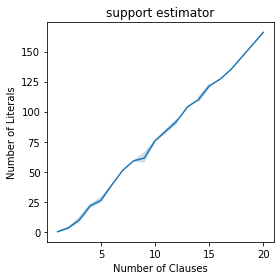

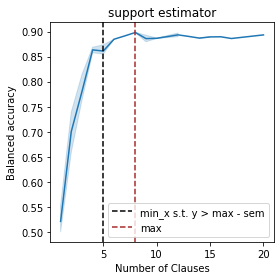

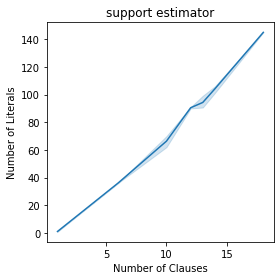

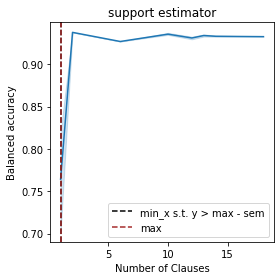

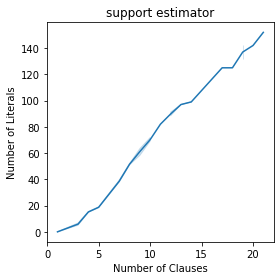

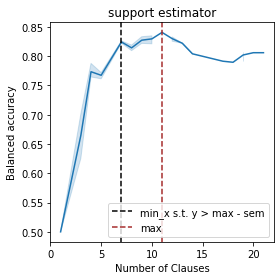

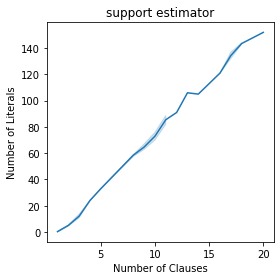

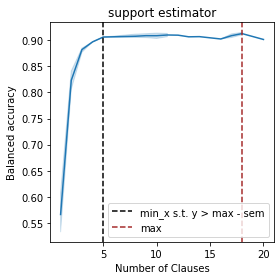

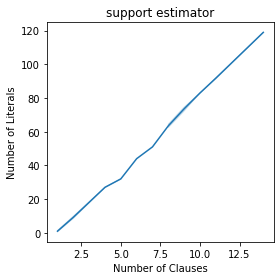

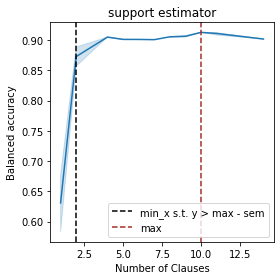

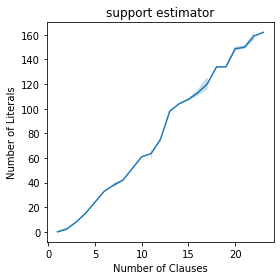

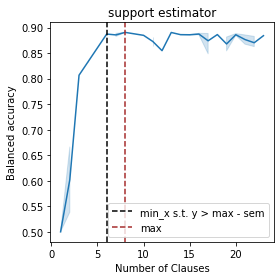

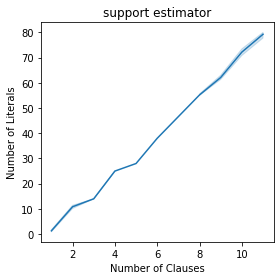

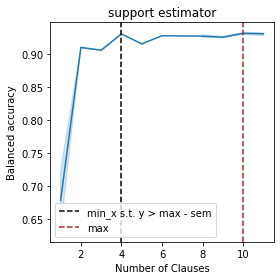

In [22]:
RESULTS = []
OPTIMS = []

for ctry, select in zip(ctrys, selects):
    DATA_PATH = folder + select
    VARENCODINGPATH = folder + 'data/varencoding-' + ctry + '.txt'
    
    results = learn_srules(logspace=10, data_path=DATA_PATH)
    RESULTS.append(results)
    
    LAMBDA_0 = np.logspace(-7, -0.1, 10)
    LAMBDA_1 = np.logspace(-7, -0.1, 10)

    i = 0
    for lambda_0 in LAMBDA_0:
        for lambda_1 in LAMBDA_1:
            results[i][4] = lambda_0
            results[i][5] = lambda_1 
            i = i +1
            
    plt_cl_lit(results)
    plt_sem(results)
    
    optim = get_sem_optim(results, rtype='support')
    OPTIMS.append(optim)

In [48]:
i = 4
ctry = ctrys[i]
optim = OPTIMS[i]
DATA_PATH = folder + selects[i]
VARENCODINGPATH = folder + 'data/varencoding-' + ctry + '.txt'

print(DATA_PATH)
print(VARENCODINGPATH)


from comp_overrule import overrulefit
X_df, a, y = get_data(DATA_PATH)

X_df = X_df[~y.isna()]
a = a[~y.isna()]
y = y[~y.isna()]
    
_, RS_s, _, auc, _ = overrulefit(X_df, a, LAMBDA0_s=optim[4], LAMBDA1_s=optim[5], only_support=True)

/home/victora/PositivityViolation/data/fp_select1623532215.csv
/home/victora/PositivityViolation/data/varencoding-zm.txt


In [49]:
overlap = get_overlap(RS_s, data_path=DATA_PATH)

overlap_Xdf = X_df.loc[X_df.index.isin(overlap)]
overlap_adf = a.loc[X_df.index.isin(overlap)]
overlap_ydf = y.loc[X_df.index.isin(overlap)]

concat_df = pd.concat((overlap_Xdf, overlap_adf, overlap_ydf), axis=1)

print(len(concat_df)/len(X_df))

O_DATA_PATH = DATA_PATH
O_DATA_PATH = O_DATA_PATH.replace('.csv', '-support.csv')
concat_df.to_csv(O_DATA_PATH, index=False)

0.9344965675057209


In [50]:
print(auc)

0.9010924392380955


In [51]:
stats = rules_stats(RS_s.rules, X_df, a)
transcript = transcribe(stats, var_encoding_path = VARENCODINGPATH)

with open('data/' + ctry + '-transcript.txt', 'w') as fp:
    fp.write(str(transcript))

In [52]:
rule_str(RS_s.rules())

'  ((X_df["v012"] > 35.500) & ~X_df["v101_6"].astype(bool) & (X_df["v133"] <= 14.500) & ~X_df["v513_2"].astype(bool) & ~X_df["v513_7"].astype(bool) & (X_df["v525"] <= 28.500))| ((X_df["v012"] <= 35.500) & (X_df["v133"] <= 14.500) & ~X_df["v513_5"].astype(bool) & ~X_df["v513_7"].astype(bool) & (X_df["v525"] <= 28.500))'

In [55]:
np.save('hypsearch', np.array(RESULTS, dtype=object))

### Learn overlap rules

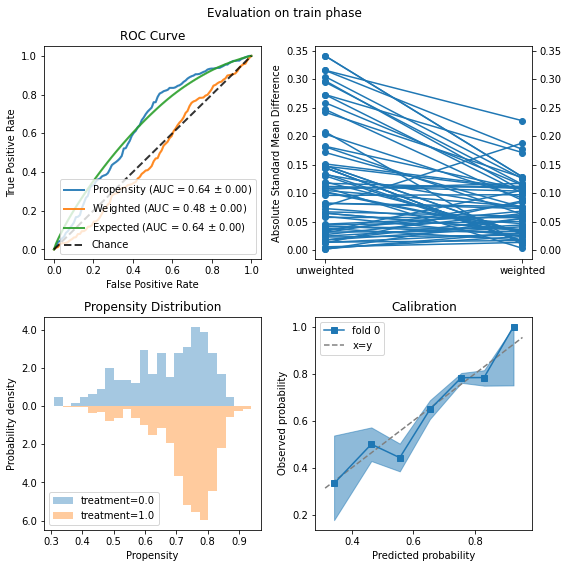

In [26]:
from comp_overrule_clr import model
from utils import write_model

evaluations, X_test, a_test, y_test = propensity_model(DATA_PATH)
bestmodel = evaluations.models.learner.steps[1][1].best_estimator_
write_model(bestmodel, 'clrmodel')

In [39]:
optim[4], optim[5]

(1e-07, 0.0006812920690579615)

In [43]:
clr_results = learn_clrrules(LAMBDA0_s=optim[4], LAMBDA1_s=optim[5], logspace=10, data_path=DATA_PATH)

100%|██████████| 10/10 [00:00<00:00, 20794.76it/s]

100%|██████████| 10/10 [00:00<00:00, 6543.38it/s]

100%|██████████| 10/10 [00:00<00:00, 44011.58it/s]

100%|██████████| 10/10 [00:00<00:00, 41943.04it/s]

100%|██████████| 10/10 [00:00<00:00, 2213.70it/s]

100%|██████████| 10/10 [00:00<00:00, 37084.92it/s]

100%|██████████| 10/10 [00:00<00:00, 27288.90it/s]

100%|██████████| 10/10 [00:00<00:00, 17382.11it/s]

100%|██████████| 10/10 [00:00<00:00, 25435.44it/s]

100%|██████████| 10/10 [00:00<00:00, 114.55it/s]


In [44]:
len(clr_results)

100

(<Figure size 288x288 with 1 Axes>,
 <AxesSubplot:title={'center':'overlap estimator'}, xlabel='Number of Clauses', ylabel='Balanced accuracy'>)

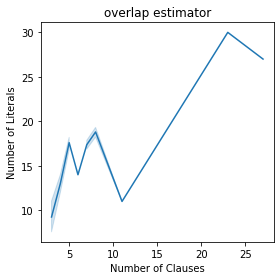

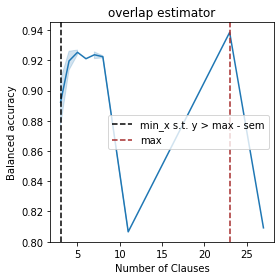

In [45]:
plt_cl_lit(clr_results, rtype='overlap')
plt_sem(clr_results, rtype='overlap')

In [46]:
LAMBDA_0 = np.logspace(-7, -0.1, 10)
LAMBDA_1 = np.logspace(-7, -0.1, 10)

i = 0
for lambda_0 in LAMBDA_0:
    for lambda_1 in LAMBDA_1:
        clr_results[i][4] = lambda_0
        clr_results[i][5] = lambda_1 
        i = i +1

optim_clr = get_sem_optim(clr_results, rtype='overlap')
print(optim_clr)

0.9385899814471244
[(4, 28), (3, 14), 0.9129286676110033, 0.936734693877551, 0.1359356390878527, 0.003981071705534978]


In [34]:
knn_results = learn_knnrules(LAMBDA0_s=optim[4], LAMBDA1_s=optim[5], logspace=10, data_path=DATA_PATH, kmodel=read_model(folder + '/pickle/knnmodel_1613996894_ET.pickle'))

100%|██████████| 10/10 [00:00<00:00, 470.64it/s]

100%|██████████| 10/10 [00:00<00:00, 4654.13it/s]

100%|██████████| 10/10 [00:00<00:00, 4530.46it/s]

100%|██████████| 10/10 [00:00<00:00, 17098.67it/s]

100%|██████████| 10/10 [00:00<00:00, 19887.64it/s]

100%|██████████| 10/10 [00:00<00:00, 25637.56it/s]

100%|██████████| 10/10 [00:00<00:00, 10491.01it/s]

100%|██████████| 10/10 [00:00<00:00, 21345.06it/s]

100%|██████████| 10/10 [00:00<00:00, 87.71it/s]


(<Figure size 288x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f965e4d1e48>)

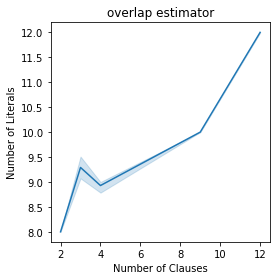

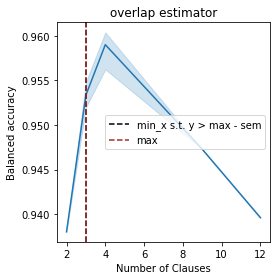

In [35]:
plt_cl_lit(knn_results, rtype='overlap')
plt_sem(knn_results, rtype='overlap')

In [36]:
LAMBDA_0 = np.logspace(-7, -0.1, 10)
LAMBDA_1 = np.logspace(-7, -0.1, 10)

i = 0
for lambda_0 in LAMBDA_0:
    for lambda_1 in LAMBDA_1:
        knn_results[i][4] = lambda_0
        knn_results[i][5] = lambda_1 
        i = i +1

optim_knn = get_sem_optim(knn_results, rtype='overlap')
print(optim_knn)

0.9672847682119206
[(3, 17), (3, 11), 0.9451723268842926, 0.9672847682119206, 0.1359356390878527, 0.0006812920690579615]


### Combined ruleset estimator

In [49]:
modelpath = folder + recent_model('clrmodel')
modelpath = '/home/victora/PositivityViolation/pickle/clrmodel_1621417062.pickle'

X_df, a, y = get_data(DATA_PATH)
len(X_df)

3405

In [51]:
DATA_PATH

'/home/victora/PositivityViolation/data/fp_et-2-select1621333412.csv'

In [52]:
M, RS_s, RS_o, auc, score_base = learn_s_orules(modelpath, optim[4], optim[5], optim_clr[4], optim_clr[5], data_path=DATA_PATH)

In [53]:
stats = rules_stats(RS_s.rules, X_df, a)
transcribe(stats, var_encoding_path=folder + 'data/varencoding-et.txt')

[['Region is not "Gambela" and',
  'Type of place of residence is  "Urban" and',
  'Type of place of residence is not "Rural" and',
  'Education in single years <= 13.5 and',
  'Unmet need is not "Unmet need for limiting"'],
 ['Region is not "Tigray" and',
  'Region is not "Addis Adaba" and',
  'Region is  "Gambela" and',
  'Heard family planning on newspaper/magazine last few months not  and',
  'Age at first sex <= 22.5 and',
  'Unmet need is not "Unmet need for limiting"'],
 ['Region is not "Addis Adaba" and',
  'Region is not "Gambela" and',
  'Type of place of residence is not "Urban" and',
  'Type of place of residence is  "Rural" and',
  'Highest educational level <= 2.5 and',
  'Education in single years <= 13.5 and',
  'Age at first sex <= 22.5'],
 ['Region is not "Addis Adaba" and',
  'Region is not "Gambela" and',
  'Type of place of residence is not "Urban" and',
  'Type of place of residence is  "Rural" and',
  'Highest educational level <= 2.5 and',
  'Education in single

In [54]:
stats = rules_stats(RS_o.rules, X_df, a)
transcribe(stats, var_encoding_path=folder + 'data/varencoding-et.txt')

[['Frequency of reading newspaper or magazine <= 1.0 and',
  'Exposure is not "Postpartum amenorrheic" and',
  'Exposure is not "Infecund, menopausal" and',
  'Unmet need is not "Never had sex" and',
  'Unmet need is not "Unmet need for spacing" and',
  'Ideal number of children <= 12.0'],
 ['Region is not "Gambela" and',
  'Cohabitation duration (grouped) is not "30+" and',
  "Respondent's current age > 22.0"],
 ['Education in single years > 2.0 and',
  'Region is not "Gambela" and',
  'Cohabitation duration (grouped) is not "30+" and',
  'Unmet need is not "Never had sex" and',
  'Age at first sex <= 19.0']]

In [41]:
overlap_index_clr, violating_index_clr = get_overlap_violations(RS_s, RS_o, data_path=DATA_PATH)

In [42]:
import pandas as pd
overlap_Xdf = X_df.loc[~X_df.index.isin(violating_index_clr)]
overlap_adf = a.loc[~X_df.index.isin(violating_index_clr)]
overlap_ydf = y.loc[~X_df.index.isin(violating_index_clr)]

concat_df = pd.concat((overlap_Xdf, overlap_adf, overlap_ydf), axis=1)

In [43]:
print(len(concat_df)/len(X_df))
concat_df.to_csv(folder + '/data/overlap_et-clr.csv', index=False)

0.8887420718816068


In [ ]:
modelpath = folder + recent_model('knnmodel')

In [45]:
modelpath = '/home/victora/PositivityViolation/pickle/knnmodel_1613996894_ET.pickle'
M, RS_s, RS_o, auc, score_base = learn_s_orules(modelpath, optim[4], optim[5], optim_knn[4], optim_knn[5], data_path=DATA_PATH)

In [46]:
stats = rules_stats(RS_o.rules, X_df, a)
transcribe(stats, var_encoding_path=folder + 'data/varencoding-et.txt')

[['Desire for more children is not "Wants within 2 years" and',
  'Exposure is not "Infecund, menopausal" and',
  'Unmet need is not "Unmet need for spacing"'],
 ['Region is not "Gambela" and',
  'Region is not "Addis Adaba" and',
  'Literacy is not "No card with required language" and',
  'Desire for more children is not "Wants, unsure timing" and',
  'Births in past year <= 0.0'],
 ['Region is not "Oromia" and',
  'Literacy is not "No card with required language" and',
  'Heard family planning on radio last few months not ']]

In [47]:
overlap_index_knn, violating_index_knn = get_overlap_violations(RS_s, RS_o, data_path=DATA_PATH)

In [48]:
import pandas as pd
overlap_Xdf = X_df.loc[~X_df.index.isin(violating_index_knn)]
overlap_adf = a.loc[~X_df.index.isin(violating_index_knn)]
overlap_ydf = y.loc[~X_df.index.isin(violating_index_knn)]

concat_df = pd.concat((overlap_Xdf, overlap_adf, overlap_ydf), axis=1)

print(len(concat_df)/len(X_df))
concat_df.to_csv(folder + '/data/overlap_et-knn.csv', index=False)

0.9323467230443975


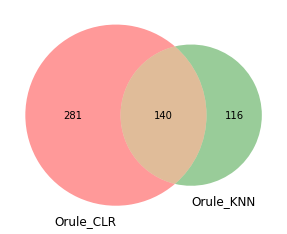

In [49]:
set1 = set(violating_index_clr)
set2 = set(violating_index_knn)

fig, ax = plt.subplots()
venn2([set1, set2], ('Orule_CLR', 'Orule_KNN'), ax=ax)

In [50]:
timestamp = str(int(time.time()))
fig.savefig(folder + 'figures/venn2' + timestamp + '.pdf')